# Ambient Populations

Some early experiments with 'ambient' population data from various sources to assess their use in COVID-19 related projects

## Initialisation

In [1]:
from bs4 import BeautifulSoup # requirement beautifulsoup4
from urllib.request import (
    urlopen, urlparse, urlunparse, urlretrieve)
import matplotlib.pyplot as plt
import os, os.path
import sys
import pandas as pd
import numpy as np

## Leeds Footfall cameras

Leeds City Council run a network of 8 cameras that count the number of passers-by every hour. The data are publicly available on [Data Mill North](https://datamillnorth.org/dataset/leeds-city-centre-footfall-data).

We have already done quite a lot of analysis with those data elsewhere so wont repeat that here. 





### Download

Each month is reported in a different file, but it's quite easy to parse the html and get the urls for each file.

The next block saves each file in the directory [./data/lcc_footfall](./data/lcc_footfall) creating those directories if necessary.

If a file is already in that directory it doesn't re-dowload it.

In [2]:
data_dir = "./data/lcc_footfall" # Where to save the csv files
if not os.path.isdir(data_dir):
    print("Creating data directory {}".format(data_dir))
    os.makedirs(data_dir)

# Connect to the Data Mill North page and parse the html
root = 'https://datamillnorth.org/dataset/leeds-city-centre-footfall-data'
soup = BeautifulSoup(urlopen(root), 'html.parser')

# Iterate over all links and see which are csv files
for link in soup.find_all('a'):
    #print("\n****",link,"****\n")
    url = link.get('href')
    if url==None: # if no 'href' tag
        continue
    
    if url.endswith(".csv"):
        filename = url.strip().split("/")[-1] # File is last part of the url
        
        # For some reason some files are duplicated
        if filename.startswith("Copy") or filename.startswith("copy"): 
            continue
        # And we don't care about xmas analysis
        if filename.startswith("Christ"):
            continue
        
        # Save the csv file (unless it already exists already)
        full_path = os.path.join("./data/lcc_footfall",filename)
        if os.path.isfile(full_path):
            print("File {} exists already, not downloading".format(filename))
        else:
            print("Downloading {}".format(filename)) 
            csv_url = "https://datamillnorth.org/"+url
            data = pd.read_csv(csv_url)
            data.to_csv(full_path)

print("Finished")

File Mar%202020.csv exists already, not downloading
File Mar%202020.csv exists already, not downloading
File Mar%202020.csv exists already, not downloading
File Feb%202020.csv exists already, not downloading
File Feb%202020.csv exists already, not downloading
File Feb%202020.csv exists already, not downloading
File Jan%202020.csv exists already, not downloading
File Jan%202020.csv exists already, not downloading
File Jan%202020.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Dec%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Dec%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Dec%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Nov%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Nov%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Nov%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20October%202019.csv exis

Read each of those files and create one big dataframe to store all the data.

In [3]:

def convert_hour(series):
    """Assumes the given series represents hours. Works out if they're 
    integers or in the format '03:00:00' and returns them as integers"""
    
    # If it's a number then just return it
    if isinstance(series.values[0], np.int64) or isinstance(series.values[0], np.float64) or isinstance(series.values[0], float):
        return series
    
    # If it's a string see if it can be made into a number
    try:
        int(series.values[0])
        return pd.to_numeric(series)
    except: # If get here then it couldn't be made into an integer
        pass
    
    if ":" in series.values[0]:
        return pd.to_numeric(series.apply(lambda x: x.strip().split(":")[0]))
    
    # If here then I don't know what to do.
    raise Exception("Unrecognised type of hours: {}".format(series))
    
# Template for our data frame. Set the type as well (default type is OK for 'location' and 'FileName')
template = pd.DataFrame(columns = ["Location", "Date", "Hour", "Count", "DateTime", "FileName"])
template["Date"] = pd.to_datetime(template["Date"], dayfirst=True)
template["Hour"] = pd.to_numeric(template["Hour"])
template["Count"] = pd.to_numeric(template["Count"])
template["DateTime"] = pd.to_datetime(template["DateTime"]) # (this one is derived from date and hour)

frames = [] # Build up a load of dataframes then merge them
total_rows = 0 # For checking that the merge works
files = [] # Remember the names of the files we tried to analyse
failures= [] # Remember which ones didn't work


# Read the files in
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        try:
            #print(filename)
            files.append(filename)
            df = pd.read_csv(os.path.join(data_dir,filename))
            
            # Check the file has the columns that we need, and work out what the column names are for this file (annoyingly it changes)
            date_col = "Date" # Doesn't change
            count_col = "Count" if "Count" in df.columns else "InCount" # Two options
            hour_col = "Hour" 
            loc_col = "Location" if "Location" in df.columns else "LocationName"
            
            if False in [date_col in df.columns, count_col in df.columns, hour_col in df.columns, loc_col in df.columns]:
                raise Exception("File '{}' is missing a column. Date? {}, Count? {}, Hour? {}, Location? {}".
                      format(filename, date_col in df.columns, count_col in df.columns, hour_col in df.columns, loc_col in df.columns))
                

            # Check if any of the columns have nans
            bad_cols = []
            for x in [date_col, count_col, hour_col, loc_col]:
                if True in df[x].isnull().values:
                   bad_cols.append(x)
            if len(bad_cols)>0:
                failures.append(filename)
                print(f"File {filename} has nans in the following columns: '{str(bad_cols)}'. Ignoring it")
                continue

            
            # Create Series' that will represent each column
            dates  = pd.to_datetime(df[date_col], dayfirst=True)
            counts = pd.to_numeric(df[count_col])
            hours  = convert_hour(df[hour_col]) # Hours can come in different forms 
            locs   = df[loc_col]
            
            # Strip whitespace from the locations
            locs   = locs.apply(lambda row: row.strip())
            
            # Derive a proper date from the date and hour
            # (Almost certainly a more efficient way to do this using 'apply' or whatever)
            dt     = pd.to_datetime(pd.Series( data = [date.replace(hour=hour) for date,hour in zip(dates,hours) ] ) )

            # Also useful to have the filename
            fnames = [filename for _ in range(len(df))]
            
            #df.apply(lambda x: x[date_col].replace(hour = x[hour_col]), axis=1)
            
            if False in [len(df) == len(x) for x in [dates, counts, hours, locs, dt]]:
                raise Exception("One of the dataframe columns does not have enough values")
            total_rows += len(df)
                
            
            # Create a temporary dataframe to represent the information in that file.
            # Note that consistent column names (defined above) are used
            frames.append(pd.DataFrame(data=
                    {"Location":locs, "Date":dates, "Hour":hours, 
                     "Count":counts, "DateTime":dt, "FileName":fnames}))
            
        except Exception as e:
            print("Caught exception on file {}".format(filename))
            raise e
            

# Finally megre the frames into one big one
merged_frames = pd.concat(frames)
if total_rows != len(merged_frames):
    raise Exception(f"The number of rows in the individual files {total_rows} does \
not match those in the final dataframe {len(merged_frames)}.")

df = template.append(merged_frames)            
print(f"Finished. Made a dataframe with {len(df)} rows. {len(failures)}/{len(files)} files could not be read.")

File Monthly%20Data%20Feed%20-%20%20Jan%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed%20-%20Dec%202017.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed%20-%20Nov%202017.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed-April%202017%20-%2020170510.csv has nans in the following columns: '['Date', 'InCount', 'Hour', 'Location']'. Ignoring it
File Monthly%20Data%20Feed-Feb%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed-March%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
Finished. Made a dataframe with 646294 rows. 6/58 files could not be read.


### Sanity check and cleaning

#### Missing Values 

Check there are no missing values

In [4]:
df.isnull().sum()

Location    0
Date        0
Hour        0
Count       0
DateTime    0
FileName    0
dtype: int64

#### Duplicate rows

Check that we have the expected number of locations, and entries per location, and total footfall at each location.

In [5]:
original_counts = df.groupby(['Location'])['Count'].agg(['sum','count'])
original_counts.reset_index() # (reset_index because it displays it nicely)

# note, same as using 'sum' function: 
#df.groupby(['Location'])["Count"].sum().reset_index()

,Location,sum,count
0,Albion Street North,58998097,72526
1,Albion Street South,90148147,83472
2,Briggate,127025472,92184
3,Briggate at McDonalds,53621982,83952
4,Commercial Street at Barratts,55805192,65232
5,Commercial Street at Lush,73102274,59208
6,Commercial Street at Sharps,25480406,24744
7,Dortmund Square,80925945,82488
8,Headrow,54261901,82488


Check that (locations, datetime) combinations are unique 

(https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count)

In [6]:
# Group by location and datetime, counting the number of occurrences
group = df.groupby(['Location','DateTime']).size().reset_index().rename(columns={0:'NumUniqueRows'})
if len(group[group.NumUniqueRows > 1]) > 1:
    print(f"There are {len(group[group.NumUniqueRows > 1])} non-unique location/datetime combinations")
    print(group[group.NumUniqueRows > 1])

There are 6768 non-unique location/datetime combinations
                   Location            DateTime  NumUniqueRows
138214  Albion Street South 2017-06-01 00:00:00              2
138215  Albion Street South 2017-06-01 01:00:00              2
138216  Albion Street South 2017-06-01 02:00:00              2
138217  Albion Street South 2017-06-01 03:00:00              2
138218  Albion Street South 2017-06-01 04:00:00              2
...                     ...                 ...            ...
631049              Headrow 2018-12-12 19:00:00              2
631050              Headrow 2018-12-12 20:00:00              2
631051              Headrow 2018-12-12 21:00:00              2
631052              Headrow 2018-12-12 22:00:00              2
631053              Headrow 2018-12-12 23:00:00              2

[6768 rows x 3 columns]


Join the group back to the original data to get the full information about each row

In [7]:
temp = df.set_index(['Location','DateTime']).join(group.set_index((['Location','DateTime'])), how="left")
print(temp[temp.NumUniqueRows>1])
del temp

                                              Date  Hour  Count  \
Location            DateTime                                      
Albion Street South 2017-06-01 00:00:00 2017-06-01     0     40   
                    2017-06-01 00:00:00 2017-06-01     0     40   
                    2017-06-01 01:00:00 2017-06-01     1     28   
                    2017-06-01 01:00:00 2017-06-01     1     28   
                    2017-06-01 02:00:00 2017-06-01     2     13   
...                                            ...   ...    ...   
Headrow             2018-12-12 21:00:00 2018-12-12    21    301   
                    2018-12-12 22:00:00 2018-12-12    22    280   
                    2018-12-12 22:00:00 2018-12-12    22    280   
                    2018-12-12 23:00:00 2018-12-12    23    174   
                    2018-12-12 23:00:00 2018-12-12    23    174   

                                                                           FileName  \
Location            DateTime             

And can find specific entiries like:

In [8]:
df[(df.DateTime==pd.to_datetime("2017-06-01 01:00:00")) & (df.Location=="Albion Street South")]

,Location,Date,Hour,Count,DateTime,FileName
1,Albion Street South,2017-06-01,1,28,2017-06-01 01:00:00,Monthy%20Data%20Feed%20-%20June%202017.csv
721,Albion Street South,2017-06-01,1,28,2017-06-01 01:00:00,Monthy%20Data%20Feed%20-%20June%202017.csv


I don't understand why there are duplicates. Part of this is errors in the csv files; e.g. `Monthy%20Data%20Feed%20-%20June%202017.csv` has duplicates for `Albion Street South`. 

For now just remove duplicates that have the same counts.

In [9]:
# Try dropping duplicates temporarily first. If it works then do it in place in the main df
df_without_duplicates = df.drop_duplicates()
#df_without_duplicates = df.drop_duplicates(subset=["Location", "DateTime", "Count"])
temp = df_without_duplicates.groupby(['Location','DateTime']).size().reset_index().rename(columns={0:'NumUniqueRows'})
print(f"There are {len(temp[temp.NumUniqueRows>1])} duplicates left")
if len(temp[temp.NumUniqueRows>1]) > 0:
    print(temp[temp.NumUniqueRows>1])
    raise Exception("Still have duplicates, should not continue")
# Make the change permanent
df.drop_duplicates(inplace=True)
#df.drop_duplicates(subset=["Location", "DateTime", "Count"], inplace=True)
del temp

There are 0 duplicates left


See how much footfall we lost

In [10]:
diff = pd.concat([df.groupby(['Location'])['Count'].agg(['sum','count']), original_counts], axis=1)
diff["Difference"]= diff.iloc[:,0] - diff.iloc[:,2]
diff["PDifference"]= 100 * (diff.iloc[:,0] - diff.iloc[:,2]) / diff.iloc[:,0]
diff

,sum,count,sum,count,Difference,PDifference
Location,,,,,,
Albion Street North,58998097,72526,58998097,72526,0,0.000000
Albion Street South,88761178,81744,90148147,83472,-1386969,-1.562585
Briggate,125291209,91176,127025472,92184,-1734263,-1.384186
Briggate at McDonalds,52998604,82944,53621982,83952,-623378,-1.176216
Commercial Street at Barratts,55805192,65232,55805192,65232,0,0.000000
Commercial Street at Lush,73102274,59208,73102274,59208,0,0.000000
Commercial Street at Sharps,24265760,23736,25480406,24744,-1214646,-5.005596
Dortmund Square,79950938,81480,80925945,82488,-975007,-1.219507
Headrow,53386088,81480,54261901,82488,-875813,-1.640527


#### Start and end dates for each camera

See when the readings for each camera start and end

In [11]:
for l in df.Location.unique():
    first = min(df.loc[ df.Location==l, "DateTime"])
    last  = max(df.loc[ df.Location==l, "DateTime"])
    print(f"Location: {l}: First: {first.date()} Last:{last.date()}")

Location: Albion Street South: First: 2008-08-16 Last:2020-03-31
Location: Briggate: First: 2007-07-20 Last:2020-03-31
Location: Briggate at McDonalds: First: 2008-06-27 Last:2020-03-31
Location: Commercial Street at Sharps: First: 2015-06-01 Last:2020-03-31
Location: Dortmund Square: First: 2008-08-27 Last:2020-03-31
Location: Headrow: First: 2008-08-27 Last:2020-03-31
Location: Albion Street North: First: 2008-08-16 Last:2018-12-12
Location: Commercial Street at Barratts: First: 2009-07-17 Last:2018-12-12
Location: Commercial Street at Lush: First: 2008-06-27 Last:2015-05-31


It looks like on `2015-05-31`, `Commercial Street at Lush` moved to `Commercial Street at Sharps`. Lets combine them

In [12]:
total_before = sum( df.loc[ (df.Location=="Commercial Street at Lush") | \
                            (df.Location=="Commercial Street at Sharps"), "Count"] )

df.loc[ (df.Location=="Commercial Street at Lush") | \
        (df.Location=="Commercial Street at Sharps"), \
               'Location' ] = "Commercial Street Combined"

# Check the total footfall in those two Commercial Street locations hasn't changed
assert sum(df.loc[df.Location=="Commercial Street Combined", "Count"]) == total_before

df.groupby(['Location'])['Count'].agg(['sum','count'])

,sum,count
Location,,
Albion Street North,58998097,72526
Albion Street South,88761178,81744
Briggate,125291209,91176
Briggate at McDonalds,52998604,82944
Commercial Street Combined,97368034,82944
Commercial Street at Barratts,55805192,65232
Dortmund Square,79950938,81480
Headrow,53386088,81480


In [13]:
# Make sure no duplicates were introduced
assert len(df.loc[df.duplicated()==True])==0

Also, the cameras weren't introduced at the same time. Most are up after Dortmund Square comes on line on `2008-08-27`. Get rid of all points before them

In [14]:
df = df.loc[df.DateTime>='2008-08-27']

df.groupby(['Location'])['Count'].agg(['sum','count'])

,sum,count
Location,,
Albion Street North,58755468,72262
Albion Street South,88290330,81480
Briggate,110934042,81480
Briggate at McDonalds,51970973,81480
Commercial Street Combined,94645775,81480
Commercial Street at Barratts,55805192,65232
Dortmund Square,79950938,81480
Headrow,53386088,81480


#### Check footfall by day/week/month etc

Group the footfall by datetime.

For info, find any missing days and weeks

In [15]:
# Aggregate all locations ('DataFrameGrouped' = dfg).
# Mess around with the index so it's a dataframe with the datetime as the index and Count as the only column
dfg = df.groupby(['DateTime'])["Count"].sum().reset_index().set_index("DateTime")
# Note, can also resample the dataframe directly by using the 'on' keyword
# df.resample('D', on="DateTime").sum()

temp = dfg.resample('D').sum()
print( f" {len(temp.loc[ temp.Count == 0, 'Count'])} days have no footfall" )
temp = dfg.resample('W').sum()
print( f" {len(temp.loc[ temp.Count == 0, 'Count'])} weeks have no footfall:" )
temp = dfg.resample('M').sum()
print( f" {len(temp.loc[ temp.Count == 0, 'Count'])} months have no footfall: \n {temp.loc[ temp.Count == 0, 'Count']} ")

del temp, dfg

 840 days have no footfall
 116 weeks have no footfall:
 25 months have no footfall: 
 DateTime
2015-03-31    0
2015-12-31    0
2016-02-29    0
2016-03-31    0
2016-06-30    0
2016-07-31    0
2016-08-31    0
2016-11-30    0
2016-12-31    0
2017-01-31    0
2017-02-28    0
2017-03-31    0
2017-04-30    0
2017-09-30    0
2017-10-31    0
2017-11-30    0
2017-12-31    0
2018-01-31    0
2018-02-28    0
2018-03-31    0
2018-10-31    0
2019-04-30    0
2019-05-31    0
2019-06-30    0
2019-07-31    0
Name: Count, dtype: int64 


Does this correspond with the files that weren't read initially? They are:

In [16]:
failures

['Monthly%20Data%20Feed%20-%20%20Jan%202018.csv',
 'Monthly%20Data%20Feed%20-%20Dec%202017.csv',
 'Monthly%20Data%20Feed%20-%20Nov%202017.csv',
 'Monthly%20Data%20Feed-April%202017%20-%2020170510.csv',
 'Monthly%20Data%20Feed-Feb%202018.csv',
 'Monthly%20Data%20Feed-March%202018.csv']

Hardly any days have hours missing. Ignore it.

In [17]:
# This will make lots of columns, each with counts. Most should be '24'
temp = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='D')] ).count().reset_index()
temp.loc[temp.Date<24]

,Location,DateTime,Date,Hour,Count,FileName
2726,Albion Street North,2017-07-01,23,23,23,23
2878,Albion Street North,2018-07-02,23,23,23,23


XXXX HERE Maybe delete following cell

Lots of days have 0 counts, but I think these are actually missing days that get introduced during the aggregation (there's probably something about this in the `resample` funnction). 

In the tables below, after aggregation, there are days with 0 counts. But if you look up those days in the original dataframe there is no data for them. 

I think what's happenning is there are some long periods of time with missing data. The graphs later show this clearerly. This means that adding all footfall together (sum) will introduce errors where parts of (e.g.) months are missing. Averaging (mean) should avoid these problems. 

I wont do anything about this now but it's worth keeping in mind for later.

In [18]:
temp = df.resample('M', on="DateTime").sum().reset_index()
days_with_zero = temp.loc[temp.Count < 1, ["DateTime", "Count"] ]
days_with_zero

# The following would show that if you put these dates into the original df there is no data there
#for date in days_with_zero["DateTime"]:
#    print(date)
#    print(df.loc[ (df.DateTime>=date.replace(hour=0)) & (df.DateTime<=date.replace(hour=23)) , :])

,DateTime,Count
79,2015-03-31,0
88,2015-12-31,0
90,2016-02-29,0
91,2016-03-31,0
94,2016-06-30,0
95,2016-07-31,0
96,2016-08-31,0
99,2016-11-30,0
100,2016-12-31,0
101,2017-01-31,0


Lets look at the distribution of counts per day

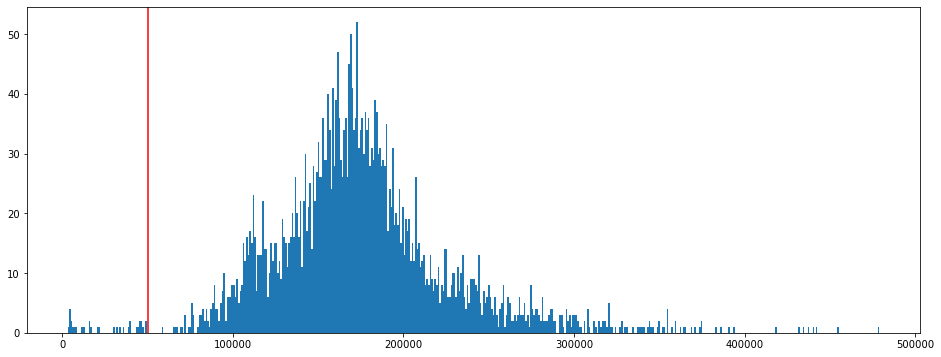

In [19]:
# Can group by date *and* location, or just date.

#temp = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='D')] ).sum().reset_index()
temp = df.groupby( [ pd.Grouper(key="DateTime", freq='D')] ).sum().reset_index()

temp = temp.loc[temp.Count > 0, :] # Remove 0s as these should really be NAs
#temp.loc[temp.Count < 1000]
#temp["Count"].hist(bins=1000)
CUTOFF = 50000
plt.figure(figsize=(16,6))
#plt.xscale('log')
plt.hist(temp["Count"],bins=500)
plt.axvline(x=CUTOFF, color="red")
plt.show()


#temp = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='D')] ).sum().reset_index()
#temp.loc[temp.Count < 1000]

Even with a very low cutoff, most of those days actually look like they're correct (e.g. many are xmas day).So I wont remove any

In [20]:
temp2 = temp.loc[temp.Count<CUTOFF]
print(f"These {len(temp2)} days have counts below the cutoff:")
temp2

These 34 days have counts below the cutoff:


,DateTime,Hour,Count
120,2008-12-25,1932,4110
127,2009-01-01,1932,29984
228,2009-04-12,1932,39376
485,2009-12-25,2208,3053
492,2010-01-01,2208,35794
585,2010-04-04,2208,46456
850,2010-12-25,2208,4572
857,2011-01-01,2208,47767
970,2011-04-24,2208,45638
1215,2011-12-25,2208,4209


In [21]:
# cleanup
del temp, temp2

Optionally save to a csv file

In [22]:
# Optionally save as a csv file for reading elsewhere
#df.to_csv("data/lcc_footfall_combined.csv")

### Manual checking

Choose a few dates, times, locations and check the data in the dataframe match those in the raw file. I've been doing this by openning a few of the csv files in excel, creating a pivot table to show counts per day and hour, and then comparing those numbers to the ones in the aggregate file.

Use file [`monthly-data-feed-aug-2014-20140904.csv`](./data/lcc_footfall/monthly-data-feed-aug-2014-20140904.csv).

In [23]:
#dfg = df.groupby(['DateTime'])['Count'].sum()
dfg = df.groupby(['DateTime'])["Count"].sum().reset_index().set_index("DateTime")

# Check time for one hour
assert dfg.loc[dfg.index==pd.to_datetime("2014-08-20 10:00:00"), "Count" ].values[0] == 8370

# Check time for a day
assert sum(dfg.loc[ (dfg.index>=pd.to_datetime("2014-08-20 00:00:00")) & \
                (dfg.index<pd.to_datetime("2014-08-21 00:00:00")) , "Count"]) == 175942

# Check time for a single row
assert  df.loc[ (df.DateTime==pd.to_datetime("2014-08-23 15:00:00") ) & \
                (df.Location=="Headrow"), "Count" ].values[0] == 1838



Use file [`Monthly%20Data%20Feed-October%202015%20-%2020151203.csv`](./data/lcc_footfall/Monthly%20Data%20Feed-October%202015%20-%2020151203.csv)

In [24]:
# Check time for one hour
assert dfg.loc[dfg.index==pd.to_datetime("2015-10-20 10:00:00"), "Count" ].values[0] == 7811

# Check time for a day
assert sum(dfg.loc[ (dfg.index>=pd.to_datetime("2015-10-20 00:00:00")) & \
                (dfg.index<pd.to_datetime("2015-10-21 00:00:00")) , "Count"]) == 167152

# Check time for a single row
assert  df.loc[ (df.DateTime==pd.to_datetime("2015-10-20 23:00:00") ) & \
                (df.Location=="Albion Street North"), "Count" ].values[0] == 48

In [25]:
del dfg



### Plot Footfall

#### All footfall (every hourly count)

All cameras

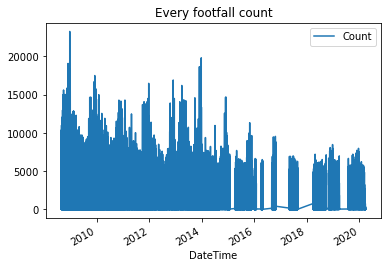

In [26]:
df.plot(x="DateTime", y="Count", title="Every footfall count")

Separate cameras

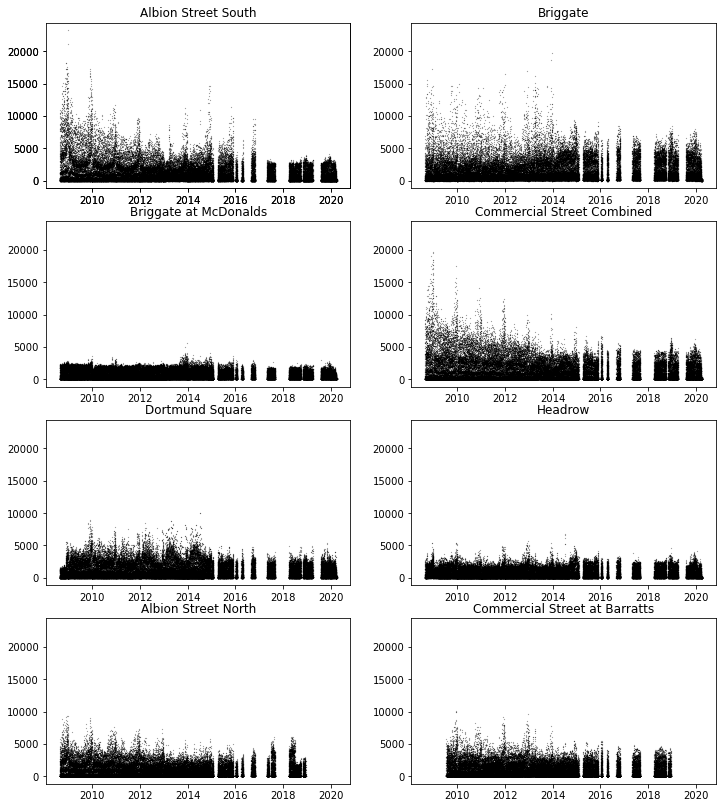

In [27]:
# plots for each location
fig = plt.figure(figsize=(12,14))
fig.tight_layout()
# Create a template axis fromBriggate (this has the most footfall). This will be overridden
shared_ax = fig.add_subplot(4, 2, 1) # rows, cols, indexsharex=ax
data = df.loc[ df.Location == "Briggate" , :]
shared_ax.scatter(data.DateTime, data.Count)

for i, loc in enumerate(df["Location"].unique()):
    ax = fig.add_subplot(4, 2, i+1, sharex=shared_ax, sharey=shared_ax) # rows, cols, index
    data = df.loc[ df.Location ==loc , :]
    ax.scatter(data.DateTime, data.Count, s=0.02, c="black")
    ax.set_title(f"{loc}")
    #df.loc[ df.Location =="Briggate" , :].plot(x="DateTime", y="Count", title=f"All footfall in {loc}")

#### Footfall by day, week, month

Total (sum) footfall **by Day**.

_Note: need to use a `Grouper` to group on DateTime and Location_. Details [here](https://stackoverflow.com/questions/32012012/pandas-resample-timeseries-with-groupby)

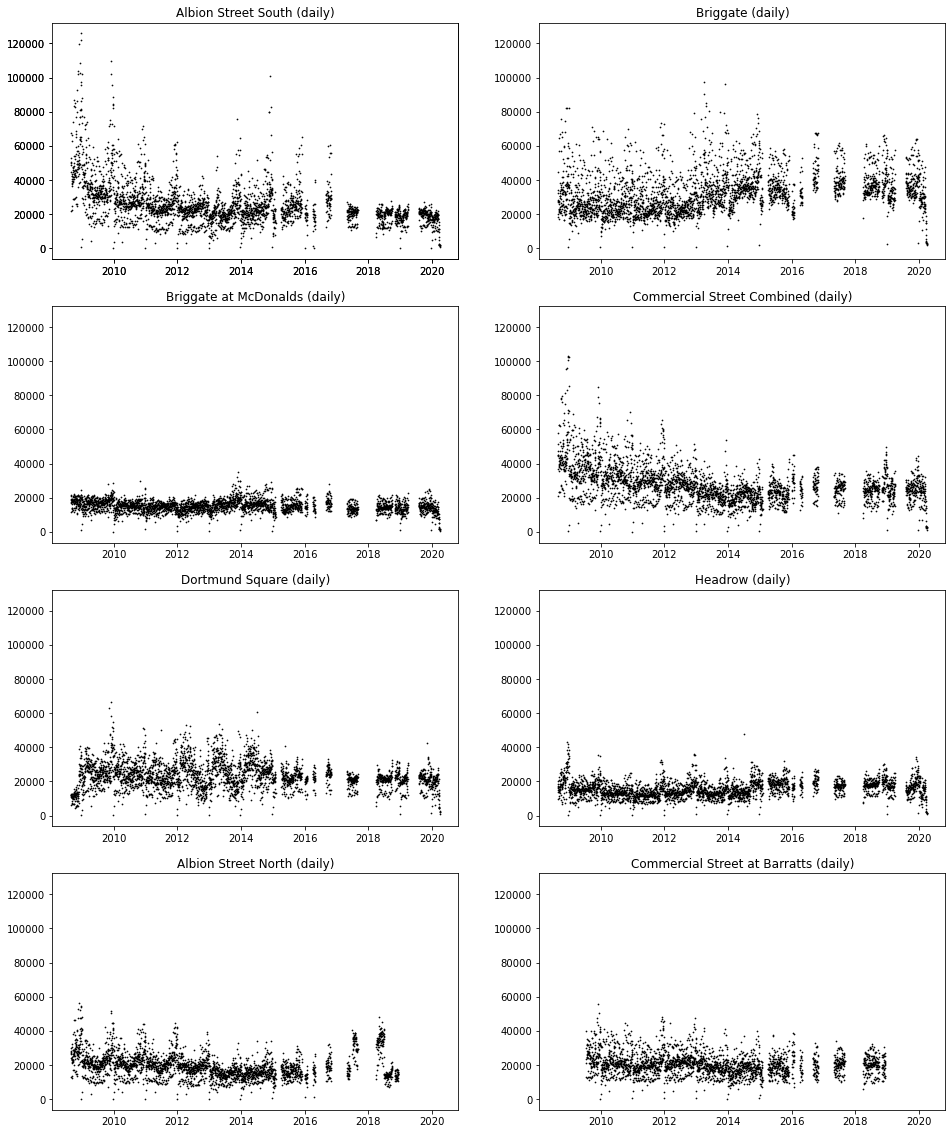

In [28]:
fig = plt.figure(figsize=(16,20))
fig.tight_layout()

# Group by location *And& 
data = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='D')] ).sum().reset_index()
data = data.loc[data.Count > 0, :] # Remove 0s that were introduced by the aggregation

# Create a template axis fromBriggate (this has the most footfall). This will be overridden
shared_ax = fig.add_subplot(4, 2, 1) # rows, cols, indexsharex=ax
shared_ax.scatter(data.loc[data.Location=="Briggate","DateTime"], data.loc[data.Location=="Briggate","Count"])
for i, loc in enumerate(df["Location"].unique()):
    ax = fig.add_subplot(4, 2, i+1, sharex=shared_ax, sharey=shared_ax) # rows, cols, index
    d = data.loc[ data.Location ==loc , :]
    ax.scatter(d.DateTime, d.Count, s=0.5, c="black")
    ax.set_title(f"{loc} (daily)")

Text(0.5, 1.0, 'Footfall by day - all cameras')

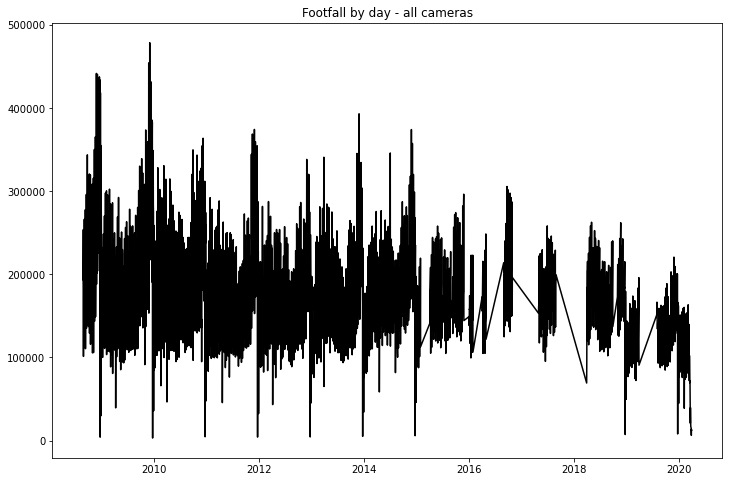

In [29]:
fig = plt.figure(figsize=(12,8))
fig.tight_layout()

ax = fig.add_subplot(1, 1, 1) # rows, cols, indexsharex=ax
#data = df.groupby( [ pd.Grouper(key="DateTime", freq='D')] ).sum().reset_index()
data = df.resample('D', on="DateTime").sum().reset_index()
data = data.loc[data.Count > 0, :]

ax.plot(data.DateTime, data.Count,c="black")
ax.set_title(f"Footfall by day - all cameras")


Average (mean) footfall **by Week**.

_Note that, as mentioned earlier, sum should not be used here because some weeks will have missing data. Instead take the mean footfall per hour over the week_.

**TODO: Work out if the aggregation below works as expected.** If the aggregation introduces 0s, then these will bring the mean down. I want to calculate the mean not including any 0s (i.e. so if there is a week with only 3 days of data, include those 3 days and not another 4 days worth of zeros). I think it's OK because lots of the huge drops seen with `sum` disapear with `mean`.

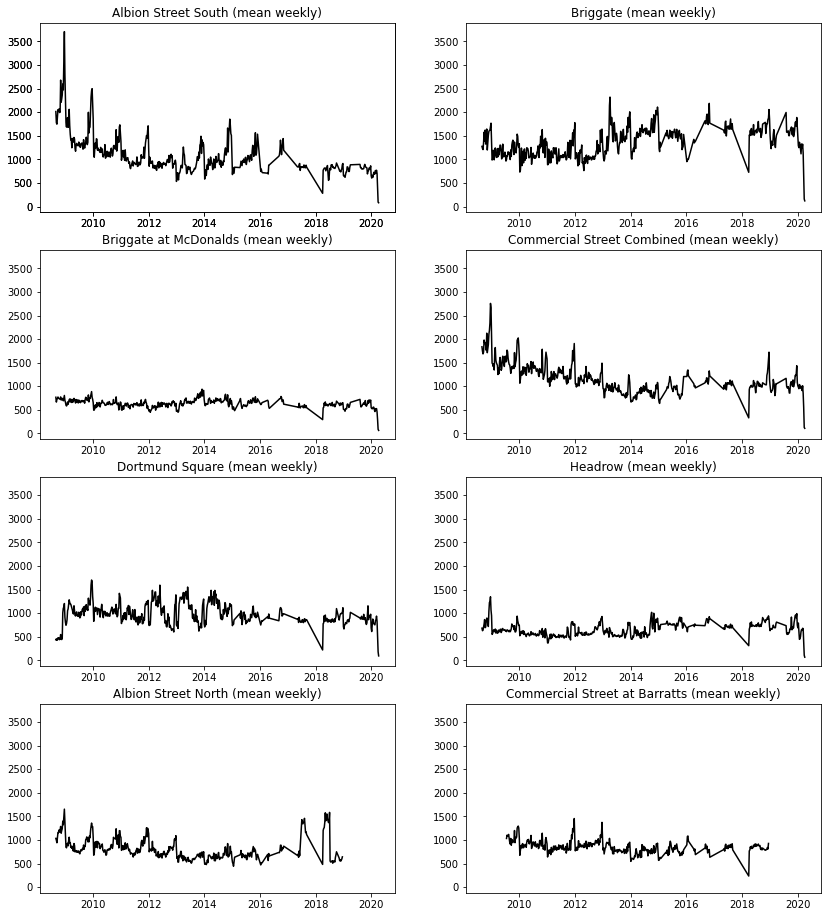

In [30]:
fig = plt.figure(figsize=(14,16))
fig.tight_layout()

AGG_FUNC = np.mean

data = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='W')] ).aggregate(AGG_FUNC).reset_index()
#data = data.loc[data.Count > 0, :] # Remove 0s that were introduced by the aggregation

# Create a template axis fromBriggate (this has the most footfall). This will be overridden
shared_ax = fig.add_subplot(4, 2, 1) # rows, cols, indexsharex=ax
shared_ax.scatter(data.loc[data.Location=="Briggate","DateTime"], data.loc[data.Location=="Briggate","Count"])
for i, loc in enumerate(df["Location"].unique()):
    ax = fig.add_subplot(4, 2, i+1, sharex=shared_ax, sharey=shared_ax) # rows, cols, index
    d = data.loc[ data.Location ==loc , :]
    #ax.scatter(d.DateTime, d.Count, s=1.0, c="black")
    ax.plot(d.DateTime, d.Count, c="black")
    ax.set_title(f"{loc} (mean weekly)")

Text(0.5, 1.0, 'Footfall by week - all cameras')

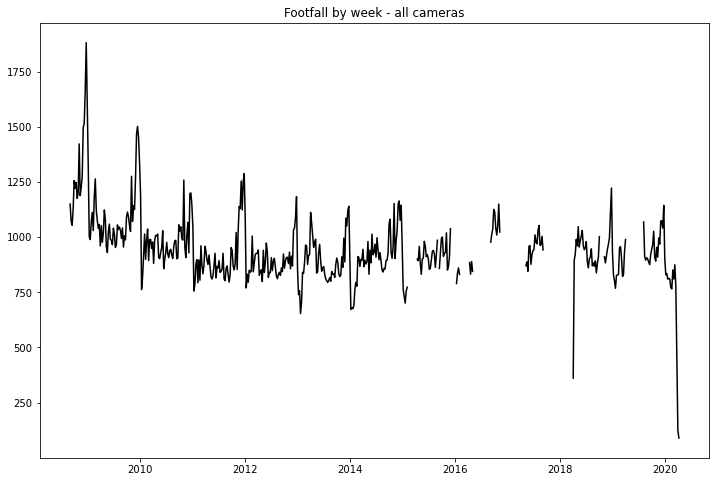

In [31]:
fig = plt.figure(figsize=(12,8))
fig.tight_layout()

AGG_FUNC = np.mean


data = df.groupby( [ pd.Grouper(key="DateTime", freq='W')] ).aggregate(AGG_FUNC).reset_index()
#data = data.loc[data.Count > 0, :] # Remove 0s that were introduced by the aggregation

ax = fig.add_subplot(1, 1, 1) # rows, cols, indexsharex=ax
ax.plot(data.DateTime, data.Count,c="black")
ax.set_title(f"Footfall by week - all cameras")


By **Month** (mean)

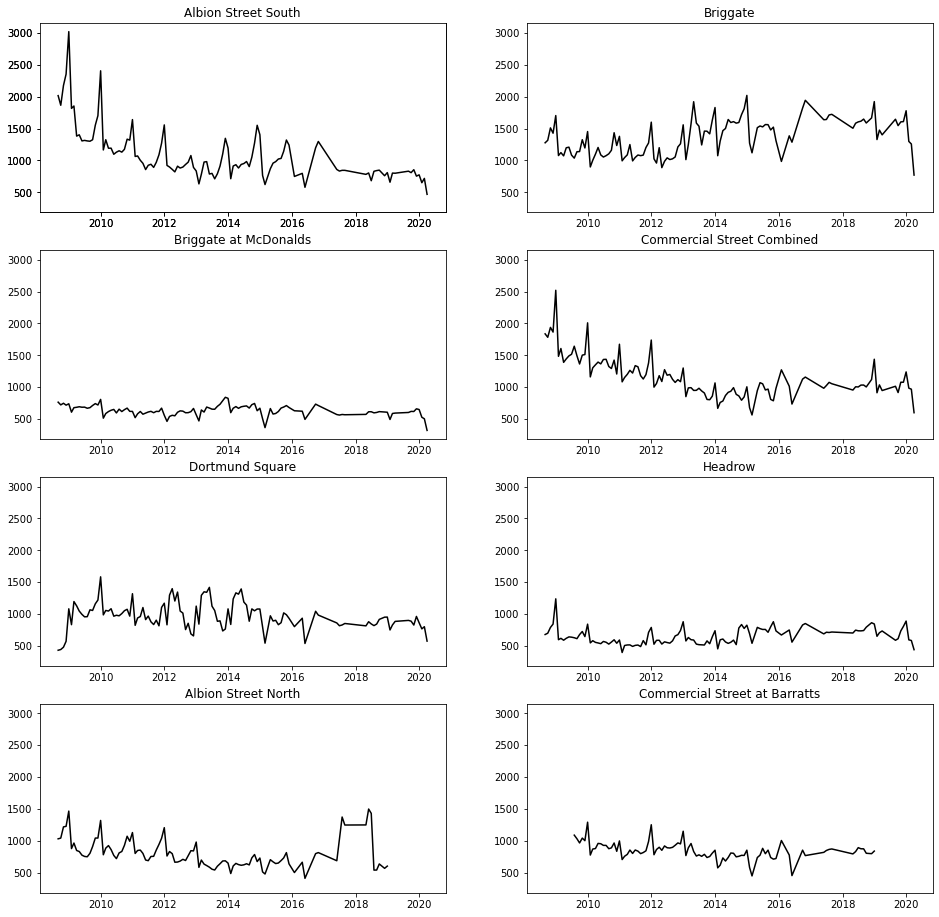

In [32]:
fig = plt.figure(figsize=(16,16))
fig.tight_layout()

AGG_FUNC = np.mean

data = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='M')] ).aggregate(AGG_FUNC).reset_index()
#data = data.loc[data.Count > 0, :] # Remove 0s that were introduced by the aggregation

# Create a template axis fromBriggate (this has the most footfall). This will be overridden
shared_ax = fig.add_subplot(4, 2, 1) # rows, cols, indexsharex=ax
shared_ax.scatter(data.loc[data.Location=="Briggate","DateTime"], data.loc[data.Location=="Briggate","Count"])
for i, loc in enumerate(df["Location"].unique()):
    ax = fig.add_subplot(4, 2, i+1, sharex=shared_ax, sharey=shared_ax) # rows, cols, index
    d = data.loc[ data.Location ==loc , :].sort_values(by="DateTime")
    ax.plot(d.DateTime, d.Count, c="black")
    ax.set_title(f"{loc}")

Text(0.5, 1.0, 'Footfall by month - all cameras')

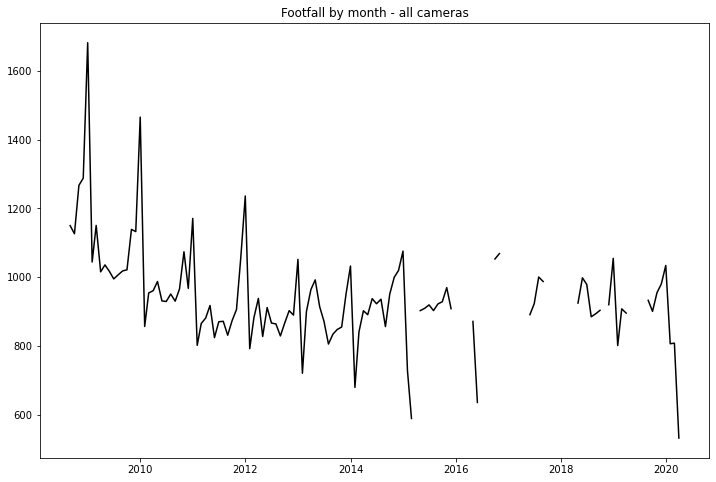

In [33]:
fig = plt.figure(figsize=(12,8))
fig.tight_layout()

AGG_FUNC = np.mean

ax = fig.add_subplot(1, 1, 1) # rows, cols, indexsharex=ax
data = df.groupby( [ pd.Grouper(key="DateTime", freq='M')] ).aggregate(AGG_FUNC).reset_index()

#data = data.loc[data.Count > 0, :] # Remove 0s that were introduced by the aggregation
ax.plot(data.DateTime, data.Count,c="black")
ax.set_title(f"Footfall by month - all cameras")


### ARIMA model of footfall

Make a model to find some outliers in the footfall patterns.

Adapting material from:
 - [ARIMA forecasting in python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Backup df because I'm going to break the original df now during testing
try:
    df_bak
except NameError:
    print("Backing up the dataframe")
    df_bak = df.copy() 
else:
    print("Backup already created")

Backing up the dataframe


ARIMA model (no seasonailty)

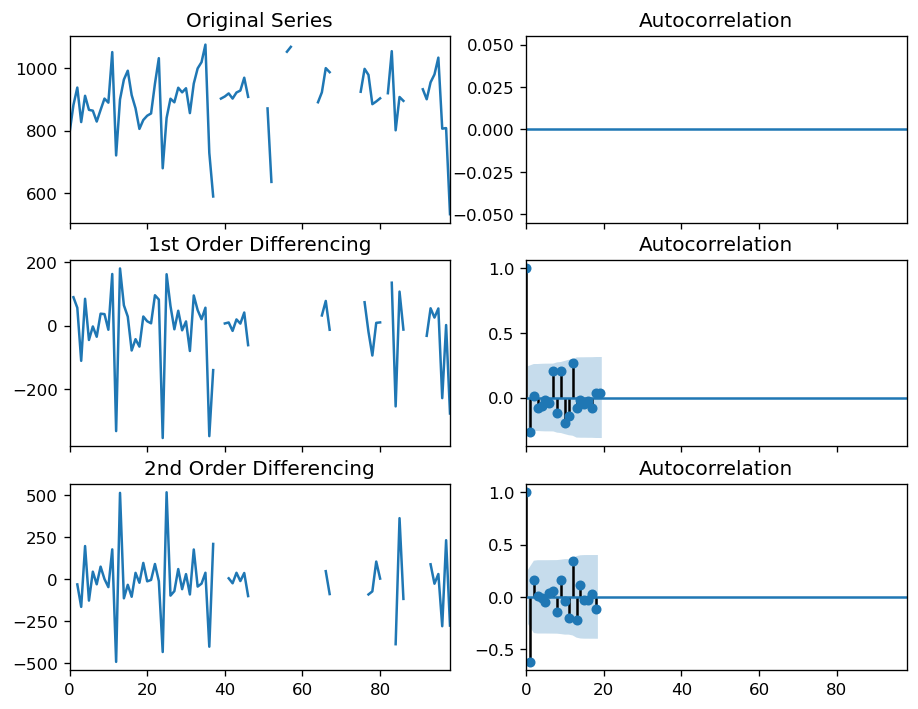

In [50]:
# Group by DateTime and ignore anything before 2012 to simplify
df = df_bak.loc[df_bak.DateTime > '2012-01-01', :].groupby( [ pd.Grouper(key="DateTime", freq='M')] )\
        .aggregate(np.mean).reset_index()

df["value"] = df.Count # So that I don't have to change the example I'm copying

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value)
axes[0, 0].set_xlim(0,max(df.index))
axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff());
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Those don't look like they're working, but I doubt they ever will because the model needs to take the seasonal component into account. Do a seasonal ARIMA next.

### SARMIA (seasonal ARMIA)

Still following instructions from the [ARIMA model blog post](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/) (section '_14. How to automatically build SARIMA model in python_').
 
Build the SARMIA model using the [pmdarima](https://alkaline-ml.com/pmdarima/setup.html#setup) package. 

_Note_ `pmdarima` was a right pain to set up as it needs relies on `statsmodels` which needs to build some c code and is sensitive to the version of packages that are already installed. I got it to work by following the instructions [here](https://stackoverflow.com/questions/50391868/python-3-5-in-statsmodels-importerror-cannot-import-name-representation). and creating a new python environment. Then installing the needed packages (plus others like `ipython` later) as so:

```
pip install numpy scipy patsy pandas
pip install statsmodels
pip install pmdarima
```

The environment I used has been exported as a yaml file [`statsmodels.yml`](./statsmodels.yml) which might make it easier to recreate using anaconda using the following:

```
conda env create -f statsmodels.yml
```

In [51]:
import pmdarima as pm

**Important**: first set the time step (weeks or months)

In [67]:
# Timestep - Whether using weeks or months. These values are needed in the various fuunctions below
freq_str, num_periods, range_str = ( 'W', 52, 'W')
#freq_str, num_periods, range_str = ( 'M', 12, 'MS')

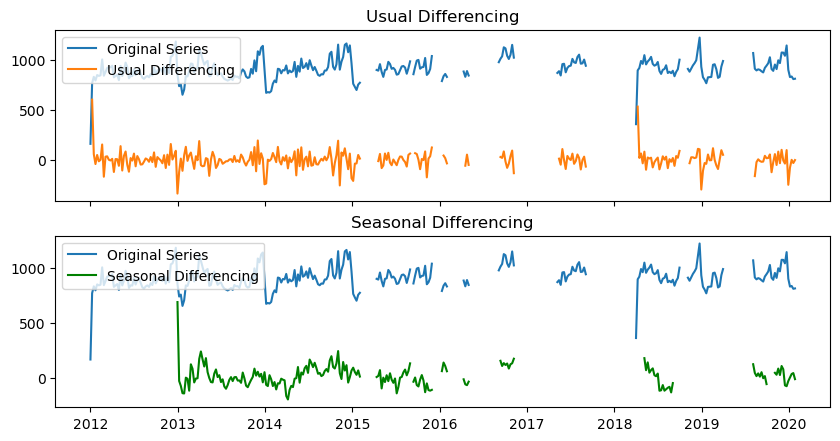

In [96]:
# Group by DateTime, ignore anything before 2012 to simplify, set the index to be the datetime
df = df_bak.loc[df_bak.DateTime > '2012-01-01', :].groupby( [ pd.Grouper(key="DateTime", freq=freq_str) ] )\
            .aggregate(np.mean).reset_index().set_index("DateTime")

df["value"] = df.Count # So that I don't have t change the example I'm copying
df = df.loc[ : , ["value"]] # Just keep the value column
df_forecast = df.loc[ df.index >= '2020-02' , ]             # Train on data up to Feb 2020,
df          = df.loc[ (df.index <= '2020-02' ) , ] # then forecast on weeks after that 
#df          = df.loc[ ~df.index.isin(df_forecast.index) , ] # (More complicated way to remove the forecast)
                                                             
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df[:], label='Original Series')
axes[0].plot(df[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df[:], label='Original Series')
axes[1].plot(df[:].diff(num_periods), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
#plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()



In [99]:
# Drop NA rows (the SARIMA models use the date so this shouldn't be a problem)
df = df.loc[ (df.value.isna()==False) , ["value"]] # Drop NA rows and keep the value column

smodel = pm.auto_arima(df, 
                       d=None,# Order of first differencing (automatically selected)
                       start_p=1, start_q=1, # Start/max values of p (order (time lags) of AR model) 
                       #max_p=3, max_q=3,     # and q (order of the MA model)
                       seasonal=True,
                       m=num_periods, # Max order in seasonal differencing - num periods per season
                       start_P=0, # Start value of P for AR of seasonal model
                       D=None, # Order of the seasonal differencing (auto select) or
                       #D=1,   # set explicitly (recommended in the blog to set to 1)
                       test='adf', # Test used to detect stationarity
                       stepwise=True,
                       error_action='raise', suppress_warnings=True, trace=True
                      )
smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 1, 52) (constant=True); AIC=3615.046, BIC=3633.664, Time=13.421 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 52) (constant=True); AIC=3735.327, BIC=3742.774, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 52) (constant=True); AIC=3620.105, BIC=3634.999, Time=9.167 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 52) (constant=True); AIC=3640.272, BIC=3655.166, Time=12.617 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 52) (constant=False); AIC=5043.663, BIC=5047.386, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 52) (constant=True); AIC=3619.390, BIC=3634.284, Time=0.293 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 1, 52) (constant=True); AIC=3617.024, BIC=3639.366, Time=14.679 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 2, 52) (constant=True); AIC=3615.763, BIC=3638.104, Time=35.911 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0, 52) (constant=True); AIC=3615.698, BIC=3634.316, Time=12.816 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 2, 52) (constant=True); AIC=3617

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  306
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 52)   Log Likelihood               -1803.414
Date:                              Tue, 14 Apr 2020   AIC                           3614.828
Time:                                      06:52:08   BIC                           3629.722
Sample:                                           0   HQIC                          3620.784
                                              - 306                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    434.4706     19.855     21.882      0.000     395.555     473.386
ar.L1          0.5209      0.023     22.630      0.000       0.476       0.566
ma.S.L52       0.1774      0.052      3.444      0.001       0.076       0.278
sigma2      7649.7075    280.340     27.287      0.000    7100.251    8199.164
===================================================================================
Ljung-Box (Q):                       25.18   Jarque-Bera (JB):              2426.34
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -1.69
Prob(H) (two-sided):                  0.96   Kurtosis:                        16.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now forecast Feb onwards using the ARIMA model and plo the actual footfall at the same time

Text(0.5, 1.0, 'SARIMA - Forecast and real footfall data from Feb 2020 onwards ')

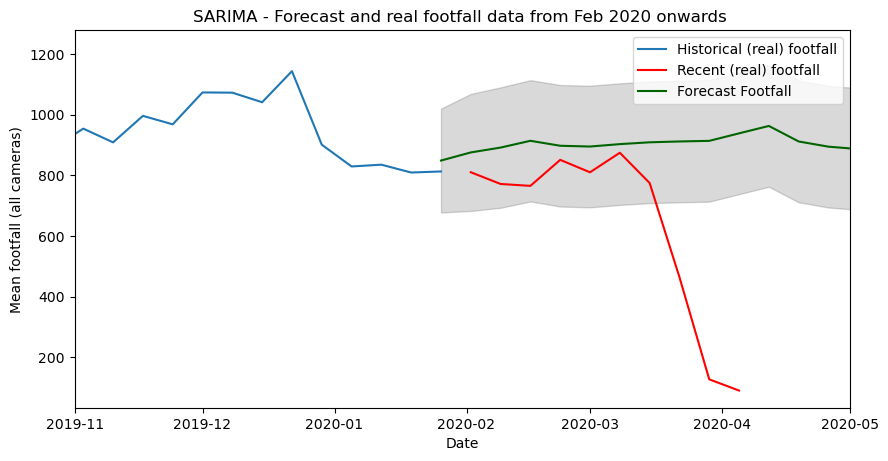

In [112]:
# Forecast
n_periods = 16 # Forecast the next N weeks / months (time periods)

fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq=range_str)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(df, label="Historical (real) footfall")
ax.plot(df_forecast, c="red", label="Recent (real) footfall")

ax.plot(fitted_series, color='darkgreen', label="Forecast Footfall")
ax.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

ax.set_ylabel("Mean footfall (all cameras)")
ax.set_xlabel("Date")

ax.set_xlim([pd.to_datetime('2019-11-01'), pd.to_datetime('2020-05-01')])

ax.legend()

ax.set_title(f"SARIMA - Forecast and real footfall data from Feb 2020 onwards ")


## Newcastle Urban Observatory

## Google Mobility Reports

### Extract mobility data (depricated)

**NOTE: Google have sinced published the data in CSV form, so the following instructions for using mobius to download the reports and extract numbers are redundant.**

Can use [mobius](https://github.com/datasciencecampus/mobility-report-data-extractor) to extract data from the graphs produced by Google's [mobility reports](https://www.google.com/covid19/mobility/) and download them.

First install the `mobius` dependencies as per: https://github.com/datasciencecampus/mobility-report-data-extractor. There are lots of dependencies so I installed them, using `poetry`, in a new anaconda environment represented as a yaml file: [`mobius.yml`](./mobius.yml). That environment can be created using:

```
conda env create -f mobius.yml
```

You also need to download the `mobius` scripts:

```
git clone https://github.com/datasciencecampus/mobility-report-data-extractor.git
```

And then the following commands will download the data locally:

```
conda activate mobius # Activate the python environment

cd mobility-report-data-extractor # Move into the mobius scripts folder

python ./mobius.py dt # Check what report dates are available

python ./mobius.py ls # Check if a country is available

# Download PDF and SVG: python ./mobius.py download <COUNTRY_CODE> <DATE>
python ./mobius.py download GB

# Process the PDF and SVG (doing the 2 available weeks currently). Note that it seems to crash without the -d flag.
python mobius.py full ./pdfs/GB_2020-03-29.pdf ./svgs/GB_2020-03-29.svg ../data/google_mobility/ -d ./config/dates_lookup_2020_03_29.csv
python mobius.py ./pdfs/GB_2020-04-05.pdf ./svgs/GB_2020-04-05.svg ../data/google_mobility/ -d ./config/dates_lookup_2020_04_05.csv
```

That will store data in the [./data/google_mobility](./data/google_mobility) directory.


### Download mobility data directly from google

The data that underpin the reports are avialable here: https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv

In [15]:
url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"
full_path = os.path.join("./data/","Global_Mobility_Report.csv")
if os.path.isfile(full_path):
    print("File {} exists already, not downloading".format(full_path))
else:
    print("Downloading {}".format(url)) 
    data = pd.read_csv(url)
    data.to_csv(full_path)

gmd = pd.read_csv(full_path)
gmd['date'] = pd.to_datetime(gmd['date'])

File ./data/Global_Mobility_Report.csv exists already, not downloading


/Users/nick/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


All countries:

In [18]:
gmd.country_region.unique()

array(['United Arab Emirates', 'Afghanistan', 'Antigua and Barbuda',
       'Angola', 'Argentina', 'Austria', 'Australia', 'Aruba',
       'Bosnia and Herzegovina', 'Barbados', 'Bangladesh', 'Belgium',
       'Burkina Faso', 'Bulgaria', 'Bahrain', 'Benin', 'Bolivia',
       'Brazil', 'The Bahamas', 'Botswana', 'Belarus', 'Belize', 'Canada',
       'Switzerland', "Côte d'Ivoire", 'Chile', 'Cameroon', 'Colombia',
       'Costa Rica', 'Cape Verde', 'Czechia', 'Germany', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Estonia', 'Egypt', 'Spain',
       'Finland', 'Fiji', 'France', 'Gabon', 'United Kingdom', 'Georgia',
       'Ghana', 'Greece', 'Guatemala', 'Guinea-Bissau', 'Hong Kong',
       'Honduras', 'Croatia', 'Haiti', 'Hungary', 'Indonesia', 'Ireland',
       'Israel', 'India', 'Iraq', 'Italy', 'Jamaica', 'Jordan', 'Japan',
       'Kenya', 'Kyrgyzstan', 'Cambodia', 'South Korea', 'Kuwait',
       'Kazakhstan', 'Laos', 'Lebanon', 'Liechtenstein', 'Sri Lanka',
       'Lithuania', '

Lancashire data:

In [23]:
gmd_lancs = gmd.loc[gmd.sub_region_1=="Lancashire",]
gmd_lancs.head()

,Unnamed: 0,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
24867,24867,GB,United Kingdom,Lancashire,NaN,2020-02-15,-12.0,-7.0,-29.0,-13.0,-4.0,2.0
24868,24868,GB,United Kingdom,Lancashire,NaN,2020-02-16,1.0,-3.0,2.0,-3.0,0.0,0.0
24869,24869,GB,United Kingdom,Lancashire,NaN,2020-02-17,8.0,-1.0,31.0,-4.0,-17.0,3.0
24870,24870,GB,United Kingdom,Lancashire,NaN,2020-02-18,8.0,-1.0,29.0,-4.0,-16.0,3.0
24871,24871,GB,United Kingdom,Lancashire,NaN,2020-02-19,1.0,-4.0,2.0,-10.0,-17.0,3.0


Here are the plot titles from the csv file and shortened versions for use in the graphs

In [45]:
plot_titles = [("Retail and recreation", "retail_and_recreation_percent_change_from_baseline"),
               ("Grocery",               "grocery_and_pharmacy_percent_change_from_baseline"),
               ("Parks",                 "parks_percent_change_from_baseline"),
               ("Transit",               "transit_stations_percent_change_from_baseline"),
               ("Workplace",             "workplaces_percent_change_from_baseline"),
               ("Residential",           "residential_percent_change_from_baseline")]

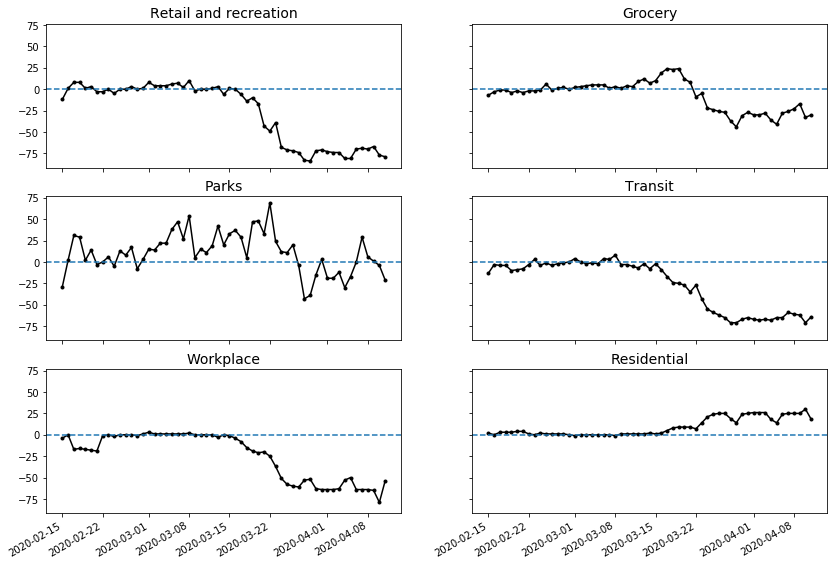

In [61]:
#fig = plt.figure(figsize=(14,10), )
fig, axes = plt.subplots(3, 2, figsize=(14,10), sharex=True, sharey=True)
#fig.tight_layout()

#fig.suptitle("Percentage change from baseline in visits to types of places", size=16) # Main title for all
    
axes_as_list = axes.reshape(-1) # Allows iterating over the axis as if they were in 1 dimension

for i, (title,column) in enumerate(plot_titles):
    ax = axes_as_list[i]
    d = gmd_lancs.loc[ :, ["date", column]].set_index("date")
    #ax.plot(x=d.date, y=d.value, c="black")
    ax.plot(d[column], c="black", marker='.')
    ax.axhline(y=0, linestyle='dashed')
    #ax.set_xlabel("Date")
    #ax.set_ylabel("Percentage change from baseline in visits to types of places")
    ax.set_title(f"{title}", size=14)

fig.autofmt_xdate() # Fix the display of dates

## Apple Mobility Reports

Apple have also made some mobility reports: https://www.apple.com/covid19/mobility . There is also a CSV file available, but I can't work out how to download it programatically (I think you need to use javascript).

In [2]:
apple_mob = pd.read_csv("./data/apple_mobility/applemobilitytrends-2020-04-15.csv")

In [6]:
apple_mob

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15
0,country/region,Albania,driving,100,95.30,101.43,97.20,103.55,112.67,104.83,...,26.40,26.03,26.43,26.70,26.32,25.47,24.89,32.64,31.43,30.67
1,country/region,Albania,walking,100,100.68,98.93,98.46,100.85,100.13,82.13,...,31.13,25.80,29.81,28.96,27.29,27.63,29.59,35.52,38.08,35.48
2,country/region,Argentina,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,...,17.24,18.55,19.95,19.80,16.80,19.40,12.89,21.10,22.29,23.55
3,country/region,Argentina,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,...,11.85,13.49,15.51,14.65,13.58,15.75,10.45,16.35,16.66,17.42
4,country/region,Australia,driving,100,102.98,104.21,108.63,109.08,89.00,99.35,...,53.17,55.01,59.24,33.19,36.00,26.95,31.72,53.14,55.91,56.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,city,Washington DC,transit,100,100.78,103.92,105.02,112.26,96.01,87.76,...,18.87,17.59,18.79,16.92,17.76,16.99,14.23,17.01,17.37,17.02
391,city,Washington DC,walking,100,99.07,109.61,104.16,123.16,119.71,106.28,...,40.76,35.97,43.18,36.12,37.50,44.63,32.84,33.58,37.56,38.69
392,city,Zurich,driving,100,102.38,110.84,105.48,113.83,109.67,102.03,...,65.57,69.43,71.98,69.31,61.38,63.78,54.97,67.09,72.52,74.89
393,city,Zurich,transit,100,101.51,108.93,97.87,103.91,98.50,93.83,...,29.56,31.39,32.01,31.32,31.35,29.18,31.49,32.90,35.71,35.68


In [8]:
apple_mob.loc[apple_mob.region=="UK"]

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15
139,country/region,UK,driving,100,104.86,106.40,104.28,109.27,108.30,94.30,...,34.74,36.06,36.67,38.05,34.40,31.74,24.46,29.72,38.71,40.02
140,country/region,UK,transit,100,104.20,105.37,103.89,109.38,115.05,99.52,...,15.80,15.57,15.59,15.45,14.92,14.17,13.50,15.29,16.35,16.64
141,country/region,UK,walking,100,106.14,114.37,112.59,128.99,157.81,101.98,...,37.16,41.70,41.69,43.55,45.19,44.40,34.94,37.14,45.40,48.31
